In [ ]:
!pip install squarify
!pip install kaleido==0.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 33.0 MB/s eta 0:00:00


In [ ]:
import kagglehub
import time
import math
import kaleido

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify as sq
import plotly.express as px

from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import MinMaxScaler

In [ ]:
course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")
course.shape

/tmp/ipython-input-3-62362134.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")


100%|██████████| 29.0M/29.0M [00:00<00:00, 106MB/s] 

Extracting zip of Course_info.csv...


(209734, 20)

In [ ]:
course['category'].unique()

array(['Lifestyle', 'Business', 'Design', 'Health & Fitness',
       'Finance & Accounting', 'Development', 'Marketing',
       'Teaching & Academics', 'IT & Software', 'Office Productivity',
       'Music', 'Personal Development', 'Photography & Video'],
      dtype=object)

In [ ]:
course.head(5)

,id,title,is_paid,price,headline,num_subscribers,avg_rating,num_reviews,num_comments,num_lectures,content_length_min,published_time,last_update_date,category,subcategory,topic,language,course_url,instructor_name,instructor_url
0,4715.0,Online Vegan Vegetarian Cooking School,True,24.99,Learn to cook delicious vegan recipes. Filmed ...,2231.0,3.75,134.0,42.0,37.0,1268.0,2010-08-05T22:06:13Z,2020-11-06,Lifestyle,Food & Beverage,Vegan Cooking,English,/course/vegan-vegetarian-cooking-school/,Angela Poch,/user/angelapoch/
1,1769.0,The Lean Startup Talk at Stanford E-Corner,False,0.00,Debunking Myths of Entrepreneurship A startup ...,26474.0,4.50,709.0,112.0,9.0,88.0,2010-01-12T18:09:46Z,NaN,Business,Entrepreneurship,Lean Startup,English,/course/the-lean-startup-debunking-myths-of-en...,Eric Ries,/user/ericries/
2,5664.0,"How To Become a Vegan, Vegetarian, or Flexitarian",True,19.99,Get the tools you need for a lifestyle change ...,1713.0,4.40,41.0,13.0,14.0,82.0,2010-10-13T18:07:17Z,2019-10-09,Lifestyle,Other Lifestyle,Vegan Cooking,English,/course/see-my-personal-motivation-for-becomin...,Angela Poch,/user/angelapoch/
3,7723.0,How to Train a Puppy,True,199.99,Train your puppy the right way with Dr. Ian Du...,4988.0,4.80,395.0,88.0,36.0,1511.0,2011-06-20T20:08:38Z,2016-01-13,Lifestyle,Pet Care & Training,Pet Training,English,/course/complete-dunbar-collection/,Ian Dunbar,/user/ian-dunbar/
4,8157.0,Web Design from the Ground Up,True,159.99,Learn web design online: Everything you need t...,1266.0,4.75,38.0,12.0,38.0,569.0,2011-06-23T18:31:20Z,NaN,Design,Web Design,Web Design,English,/course/web-design-from-the-ground-up/,E Learning Lab,/user/edwin-ang-2/


In [ ]:
course_filter_lang = course[course['language'].isin({'English'})]
course_filter_lang.shape

(123921, 20)

In [ ]:
course_filter_lang.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123921 entries, 0 to 209733
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  123921 non-null  float64
 1   title               123921 non-null  object 
 2   is_paid             123921 non-null  bool   
 3   price               123921 non-null  float64
 4   headline            123901 non-null  object 
 5   num_subscribers     123921 non-null  float64
 6   avg_rating          123921 non-null  float64
 7   num_reviews         123921 non-null  float64
 8   num_comments        123921 non-null  float64
 9   num_lectures        123921 non-null  float64
 10  content_length_min  123921 non-null  float64
 11  published_time      123921 non-null  object 
 12  last_update_date    123794 non-null  object 
 13  category            123921 non-null  object 
 14  subcategory         123921 non-null  object 
 15  topic               123371 non-null  ob

In [ ]:
#check number of unique values for each column
print(course_filter_lang.nunique().reset_index().set_axis(['Features', 'Unique Values'], axis=1).to_markdown(tablefmt='outline'))

+----+--------------------+-----------------+
|    | Features           |   Unique Values |
+====+====================+=================+
|  0 | id                 |          123921 |
|  1 | title              |          122931 |
|  2 | is_paid            |               2 |
|  3 | price              |             152 |
|  4 | headline           |          119906 |
|  5 | num_subscribers    |           18365 |
|  6 | avg_rating         |            5556 |
|  7 | num_reviews        |            4321 |
|  8 | num_comments       |            1734 |
|  9 | num_lectures       |             642 |
| 10 | content_length_min |            2757 |
| 11 | published_time     |          123853 |
| 12 | last_update_date   |            3511 |
| 13 | category           |              13 |
| 14 | subcategory        |             130 |
| 15 | topic              |            3742 |
| 16 | language           |               1 |
| 17 | course_url         |          123921 |
| 18 | instructor_name    |       

In [ ]:
#get the latest 5 years
def filter_years(data, features):
  data = data.copy()
  for col in features:
    data[col] = pd.to_datetime(data[col], utc=True)

  data[features[1]] = data[features[1]].fillna(data[features[0]])
  latest_year = data[features[0]].max().year
  last_five_year = latest_year - 5

  data = data[(data[features[0]].dt.year > last_five_year) & (data[features[1]].dt.year > last_five_year)]

  return data


course_filtered = filter_years(course_filter_lang, ['published_time', 'last_update_date'])
print(f"Last 5 years data:  {course_filtered.shape}")

Last 5 years data:  (97858, 20)


In [ ]:
def initial_data_cleaning(data):
  print("\n📌 Checking for Duplicate Values")
  print("-" * 45)
  print("\n✅ No duplicate values found. Data is clean!\n")
  print("-" * 45)

  data = data.drop_duplicates()

  print("\n📌 Automatically Checking for Missing Values")
  print("🔄 Showing missing values...\n")

  percentage = (data.isnull().sum() / data.shape[0]) * 100
  missing_values = pd.DataFrame({
      'Features': data.columns,
      'Missing Values': data.isnull().sum(),
      'Percentage': [f'{round(value,2)}%' for value in percentage]
      })
  missing_values.reset_index(drop=True, inplace=True)

  print(missing_values.to_markdown(tablefmt='rounded_outline', index=False))
  print(f'Data Shape:  {data.shape}')


initial_data_cleaning(course_filtered)


📌 Checking for Duplicate Values
---------------------------------------------

✅ No duplicate values found. Data is clean!

---------------------------------------------

📌 Automatically Checking for Missing Values
🔄 Showing missing values...

╭────────────────────┬──────────────────┬──────────────╮
│ Features           │   Missing Values │ Percentage   │
├────────────────────┼──────────────────┼──────────────┤
│ id                 │                0 │ 0.0%         │
│ title              │                0 │ 0.0%         │
│ is_paid            │                0 │ 0.0%         │
│ price              │                0 │ 0.0%         │
│ headline           │               13 │ 0.01%        │
│ num_subscribers    │                0 │ 0.0%         │
│ avg_rating         │                0 │ 0.0%         │
│ num_reviews        │                0 │ 0.0%         │
│ num_comments       │                0 │ 0.0%         │
│ num_lectures       │                0 │ 0.0%         │
│ content_leng

In [ ]:
def remove_null(data):
  null_values = data[(data['num_lectures'] == 0) |
                (data['content_length_min'] == 0) |
                ((data['avg_rating'] == 0) & (data['num_reviews'] > 0))].index

  course_dropna = data.drop(index=null_values).dropna()
  print(f'Data after cleaning: {course_dropna.shape}')

  return course_dropna


course_dropna = remove_null(course_filtered)

Data after cleaning: (89225, 20)


In [ ]:
def get_numerical_attributes(data, exclude):
  numerical = []
  print(f"Numerical Attributes:")
  for num in data.select_dtypes(include = 'number').drop(columns='id').columns:
    if num != exclude:
      numerical.append(num)
      print(f"• {num}")

  return numerical


numerical = get_numerical_attributes(course, exclude='avg_rating')

Numerical Attributes:
• price
• num_subscribers
• num_reviews
• num_comments
• num_lectures
• content_length_min


In [ ]:
#handle outliers
def outlier_handling(data, features, par, transforms=None):
  trim = data.copy()
  mask = set()

  for col in features:
    threshold = trim[col].quantile(par)
    mask.update(trim[trim[col] > threshold].index)

  trim = trim.drop(index=mask)
  transformed = trim.copy()
  if transforms:
    for cols, func in transforms:   #feature groups and math transformations
      for col in cols:  #features within a feature group
        transformed[col] = func(transformed[col])

  print(f'\n®️ Original  : {len(data)}')
  print(f'✂️ After Trim  : {len(trim)}')
  print(f'⚖️ Elimination Ratio: {round(((len(data)-len(trim))/len(data))*100,2)}%')
  print('-'*35)
  print(f'📐 Trimmed Shape      : {trim.shape} ')
  print(f'📐 Transformed Shape  : {transformed.shape} ')

  return trim, transformed


#scale data to uniform the scale
def data_scaling(data, features):
  scaler = MinMaxScaler()
  scaled = data.copy()
  scaled[features] = scaler.fit_transform(scaled[features])

  return scaled


course_trimmed, course_transformed = outlier_handling(
    course_dropna,
    features=numerical,
    par=0.9,
    transforms=[
        (['num_subscribers', 'num_reviews', 'num_comments'], np.log1p),
        (['num_lectures', 'content_length_min'], np.cbrt),
        (['price'], np.sqrt)])

course_scaled = data_scaling(course_transformed, numerical)


®️ Original  : 89225
✂️ After Trim  : 65845
⚖️ Elimination Ratio: 26.2%
-----------------------------------
📐 Trimmed Shape      : (65845, 20) 
📐 Transformed Shape  : (65845, 20) 


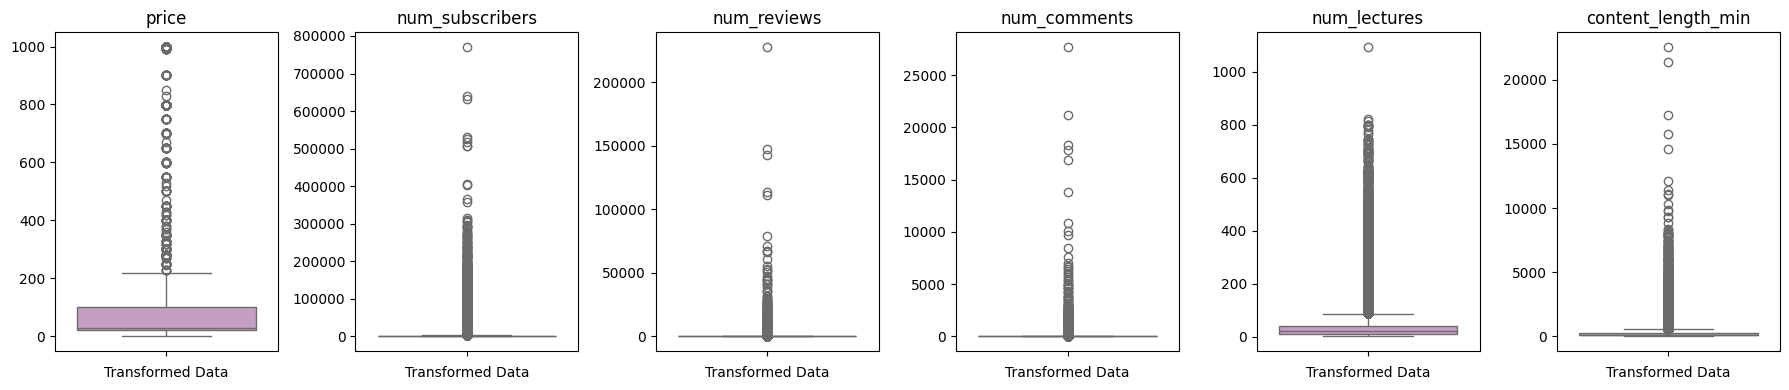

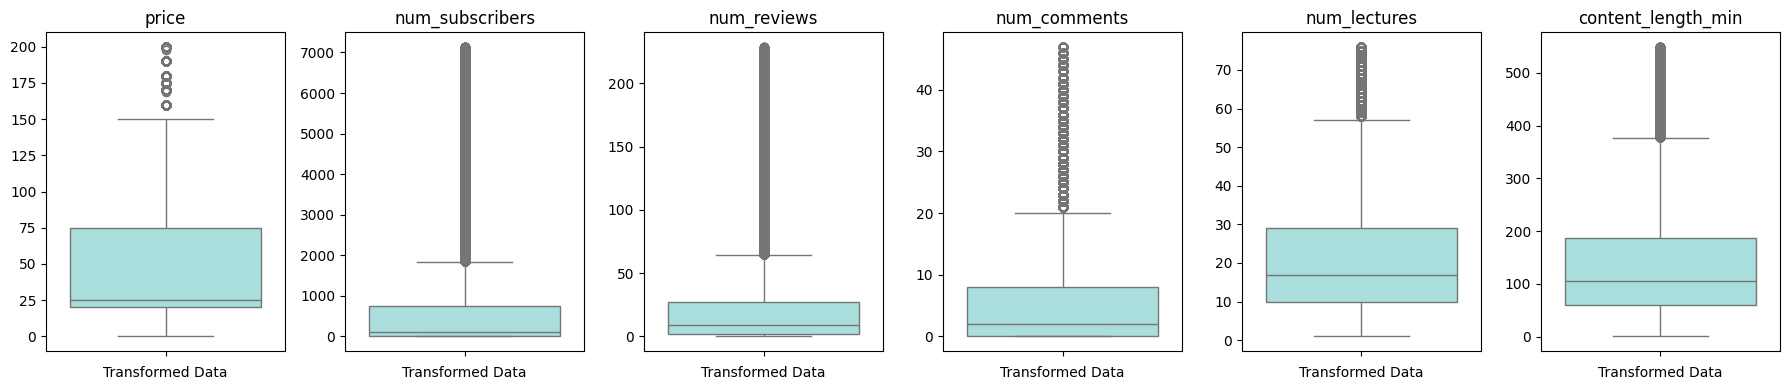

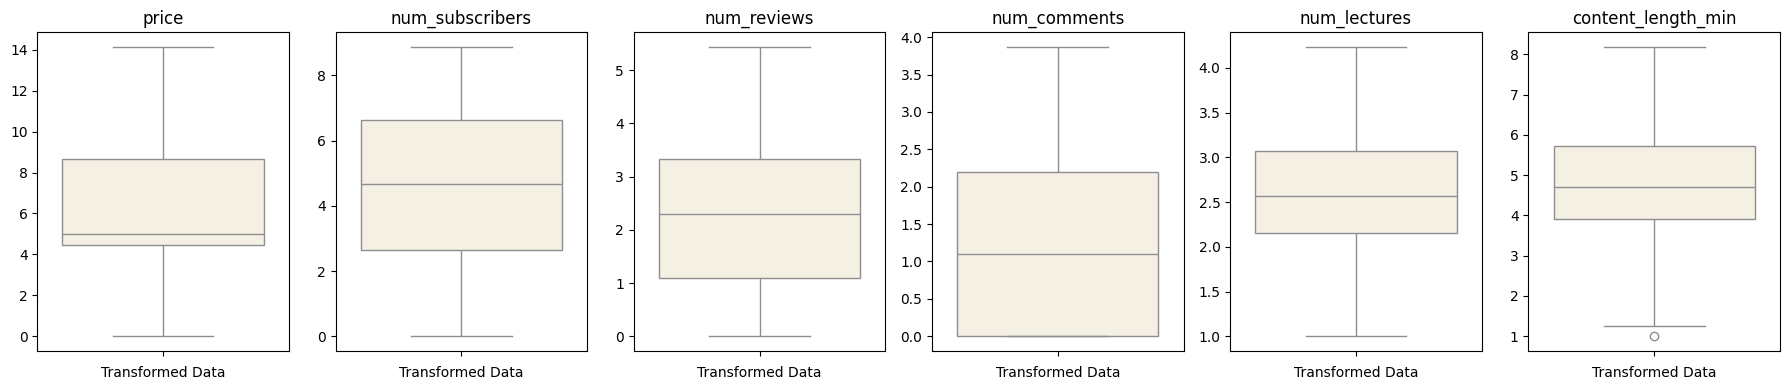

In [ ]:
def boxplot_visualization(data, features, hex):
  fig, ax = plt.subplots(1, len(features), figsize=(3 * len(features), 4))

  for i, col in enumerate(features):
    sns.boxplot(y=data[col], ax=ax[i], color=hex)
    ax[i].set_title(col)
    ax[i].set_xlabel('Transformed Data')
    ax[i].set_ylabel('')

  plt.tight_layout()
  plt.show()


boxplot_visualization(course_dropna, numerical, hex='#CB99C9')
boxplot_visualization(course_trimmed, numerical, hex='#A0E7E5')
boxplot_visualization(course_transformed, numerical, hex='#F7F1E1')

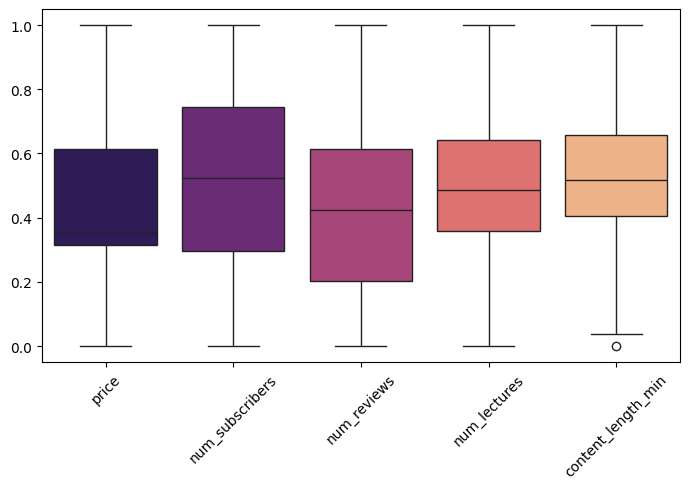

In [ ]:
def one_size_boxplots(data, features, exclude):
  numerical = [col for col in features if col != exclude]

  plt.figure(figsize=(7,5))
  sns.boxplot(data[numerical], palette='magma')
  plt.xticks(ticks=range(len(numerical)), labels=numerical, rotation=45)

  plt.tight_layout()
  plt.show()


one_size_boxplots(course_scaled, numerical, exclude='num_comments')

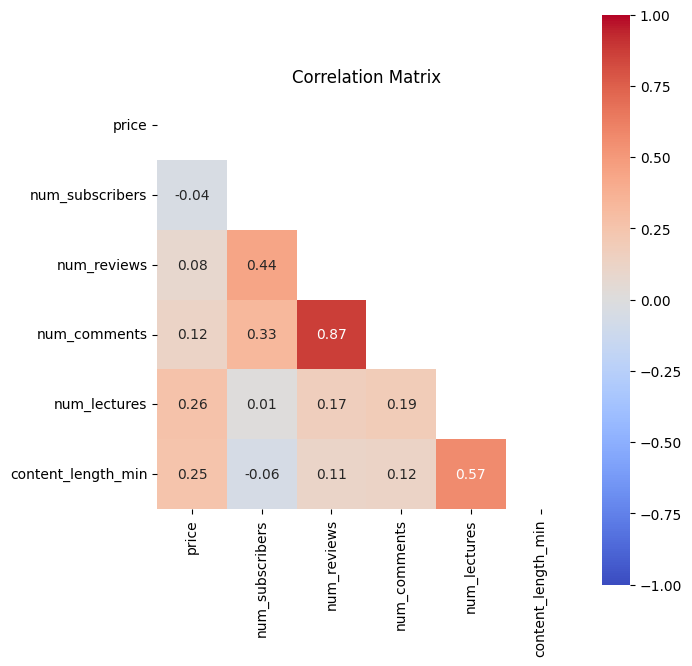

In [ ]:
def correlation_matrix(data, features):
  corr = data[features].corr().round(2)
  mask = np.triu(np.ones_like(corr, dtype=bool))
  corr = corr.mask(mask)

  plt.figure(figsize=(7,7))
  sns.heatmap(corr,
              annot=True,
              vmin=-1, vmax=1,
              cmap='coolwarm',
              square=True,
              center=0)
  plt.title('Correlation Matrix')
  plt.tight_layout()
  plt.show()


correlation_matrix(course_trimmed, numerical)

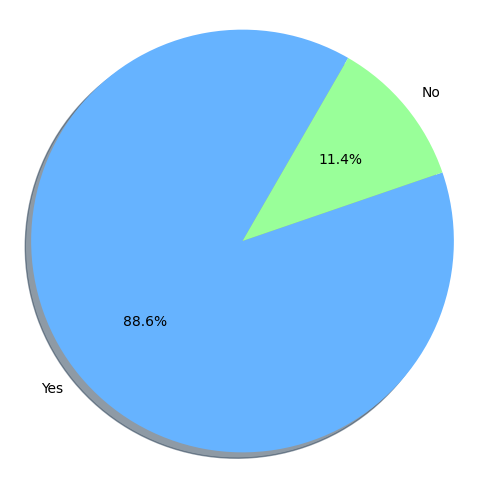

In [ ]:
def pricing_distribution(data, feature):
    colors = ['#66b3ff', '#99ff99']  # Custom colors for better contrast
    label_mapping = {True: 'Yes', False: 'No'}
    mapped_feature = data[feature].map(label_mapping)
    value_counts = mapped_feature.value_counts()


    plt.figure(figsize=(6, 6))
    plt.pie(value_counts,
            labels=value_counts.index,
            autopct='%1.1f%%',
            startangle=60,
            colors=colors,  # Apply custom colors
            shadow=True)    # Add shadow effect

    plt.axis('equal')
    plt.show()


pricing_distribution(course_trimmed, 'is_paid')

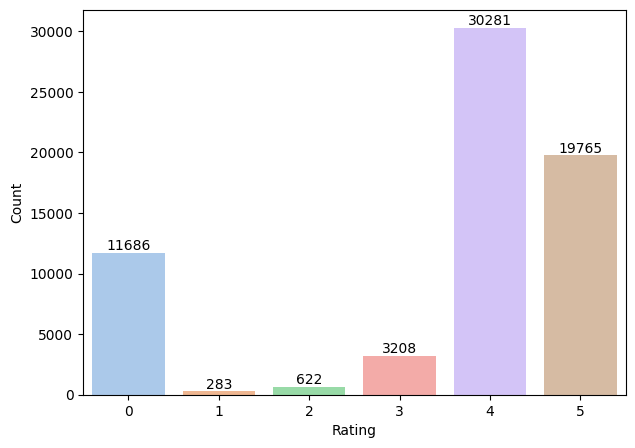

In [ ]:
def rating_distribution(data, initial_feature, rounded_feature):
  data.loc[:,rounded_feature] = data[initial_feature].round().astype(int)

  plt.figure(figsize=(7,5))
  graph = sns.countplot(x=rounded_feature, data=data, width=0.8, palette='pastel', hue=rounded_feature, legend=False)

  for bar in graph.containers:
    plt.bar_label(bar, label_type='edge')

  # plt.title('Rating Distribution')
  plt.xlabel('Rating')
  plt.ylim(0, max(data[rounded_feature].value_counts().values) + 1500)
  plt.ylabel('Count')

  plt.show()

rating_distribution(course_trimmed, initial_feature='avg_rating', rounded_feature='rating')

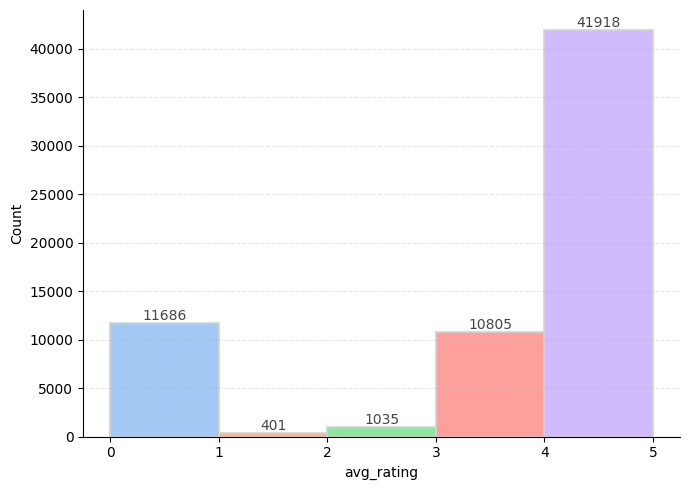

In [ ]:
def rating_histogram(data, feature):
  colors = sns.color_palette('pastel').as_hex()
  counts, bins = np.histogram(data[feature], bins=5)
  plt.figure(figsize=(7, 5))

  for i in range(len(counts)):
      plt.bar(
          x=(bins[i] + bins[i+1]) / 2,
          height=counts[i],
          width=bins[1] - bins[0],  # spacing between bars
          color=colors[i % len(colors)],
          edgecolor='lightgrey',
          linewidth=1.2
      )
      # Add bar label
      plt.text(
          x=(bins[i] + bins[i+1]) / 2,
          y=counts[i] + 0.5,
          s=str(counts[i]),
          ha='center',
          va='bottom',
          fontsize=10,
          color='#444444'
      )


  plt.grid(axis='y', linestyle='--', alpha=0.3)
  plt.xlabel(feature)
  plt.ylabel('Count')
  sns.despine()

  plt.tight_layout()
  plt.show()

# Example usage
rating_histogram(course_trimmed, 'avg_rating')

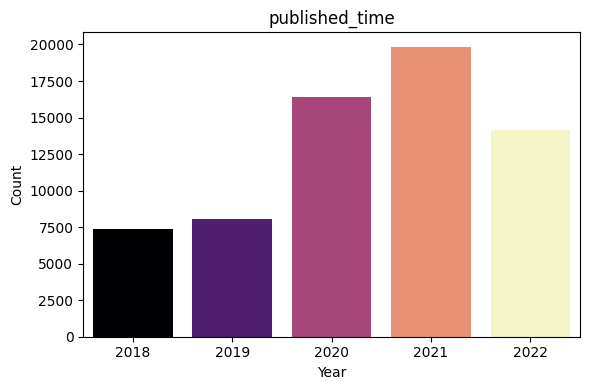

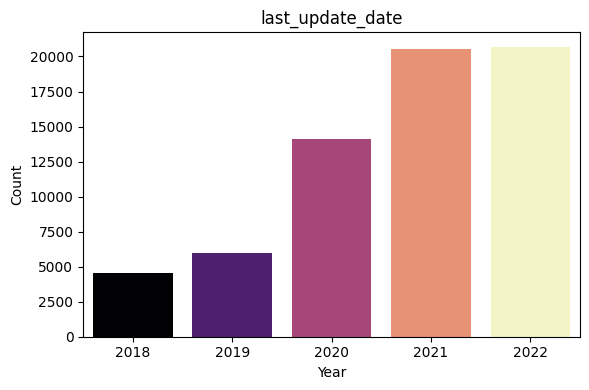

In [ ]:
def datetime_convert(data, latest_date, *features):
  latest_date = pd.to_datetime(latest_date, format='%Y-%m-%d').tz_localize(None)

  annual_dist = {}
  for col in features:
    data[col] = pd.to_datetime(data[col]).dt.tz_localize(None)
    data[f'{col}_year'] = data[col].dt.year

    pivot = pd.pivot_table(data, index=f'{col}_year', values='id', aggfunc='count')
    annual_dist[col] = pivot

  for key, value in annual_dist.items():
    plt.figure(figsize=(6, 4))
    sns.barplot(x=value.index, y=value['id'], palette='magma', hue=value.index, legend=False)
    plt.title(key)
    plt.xlabel('Year')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()


datetime_convert(course_trimmed, '2022-10-10', 'published_time', 'last_update_date')

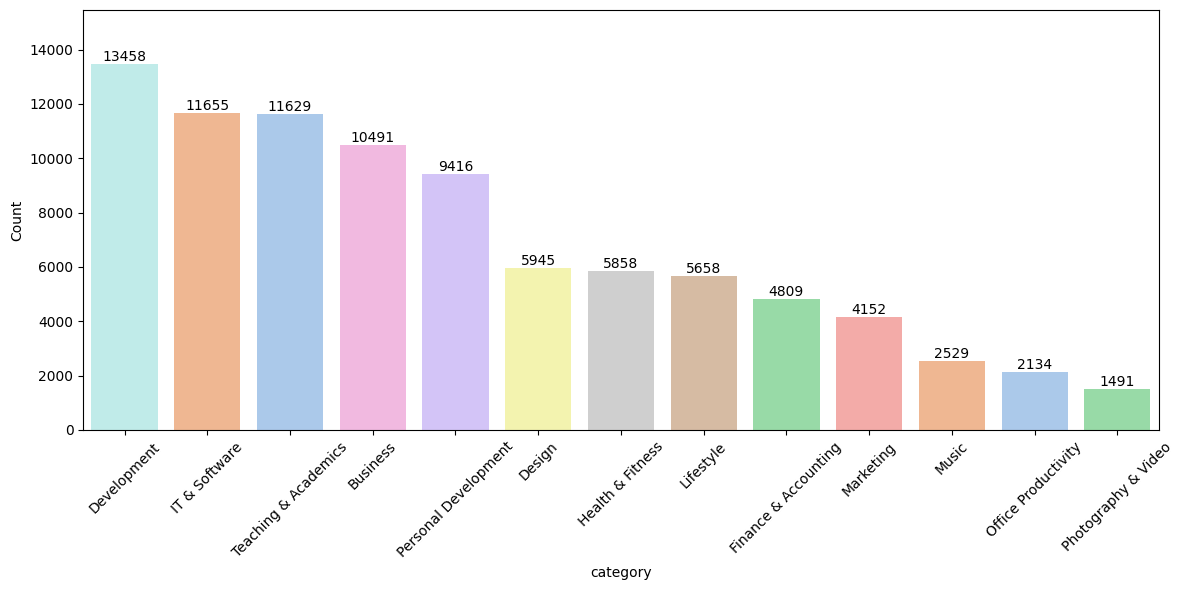

In [ ]:
def category_check(data, feature):
  plt.figure(figsize=(12,6))
  graph = sns.countplot(data=data,
                        x=feature,
                        palette='pastel',
                        order=data[feature].value_counts().index,
                        hue=feature,
                        legend=False)

  for bar in graph.containers:
    plt.bar_label(bar, label_type='edge')

  plt.xlabel(feature)
  plt.xticks(rotation=45)
  plt.ylim(0, max(data[feature].value_counts() + 2000))
  plt.ylabel('Count')
  # plt.title('Distribution of Course Category')

  plt.tight_layout()
  plt.show()

category_check(course_dropna, 'category')

In [ ]:
def treemap(data, feature, target):
    fig = px.treemap(
        data,
        path=[feature, target],
        values=[1]*len(data))

    fig.update_traces(
        texttemplate='%{label}<br>%{value} (%{percentParent:.2%})',
        textposition="middle center")

    fig.show()
    from google.colab import files
    fig.write_image("treemap.png", width=1200, height=800)

treemap(course_trimmed, 'category', 'subcategory')

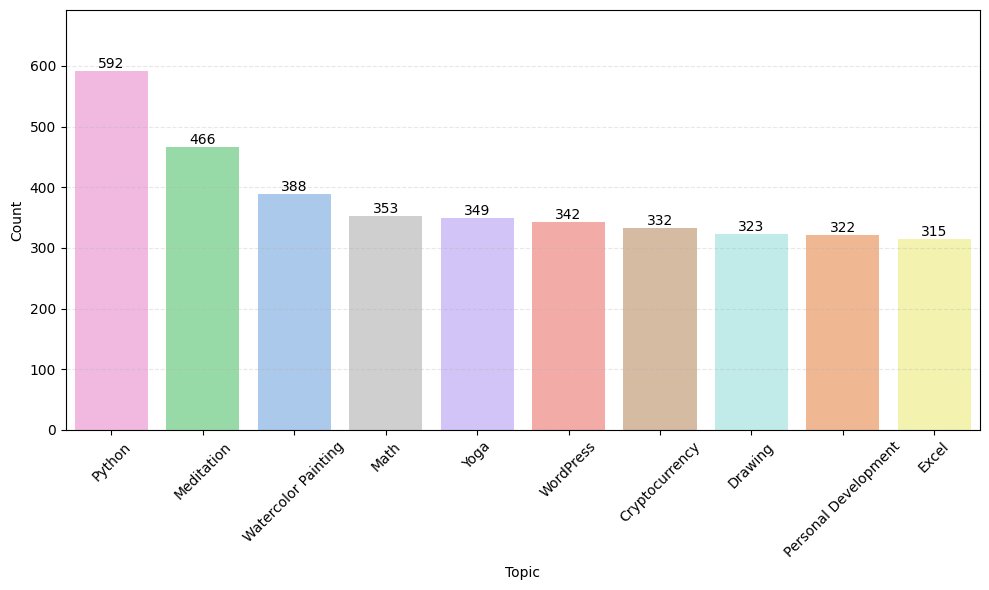

In [ ]:
def topic_check(data, feature, top_n=10):
  top_topics = data[feature].value_counts().nlargest(top_n).index
  filtered_data = data[data[feature].isin(top_topics)]

  plt.figure(figsize=(10,6))
  graph = sns.countplot(data=filtered_data,
                        x=feature,
                        palette='pastel',
                        order=top_topics,  # Ensures consistent order
                        hue=feature,
                        legend=False)

  for container in graph.containers:
      plt.bar_label(container, label_type='edge')

  plt.xlabel('Topic')
  plt.xticks(rotation=45)
  plt.ylabel('Count')
  plt.ylim(0, max(filtered_data[feature].value_counts() + 100))
  plt.grid(axis='y', linestyle='--', alpha=0.3)


  plt.tight_layout()
  plt.show()

topic_check(course_trimmed, 'topic')

In [ ]:
web_topics = course_trimmed['topic'][course_trimmed['topic'].str.contains("web", case=False, na=False)]
math_topics = course_trimmed['topic'][course_trimmed['topic'].str.contains("Excel", case=False, na=False)]
python_topics = course_trimmed['topic'][course_trimmed['topic'].str.contains("python", case=False, na=False)]
print((math_topics.unique()))
# print((design_topics.unique()))

['Excel' 'Excel Modeling' 'Excel VBA' 'Excel Shortcuts and Tips'
 'Excel Analytics' 'Excel Dashboard' 'Excel Formulas and Functions'
 'Excel Charts' 'Excel Macros']


In [ ]:
def check_instructor(data, feature):
    value_counts = data[feature].value_counts()
    percentages = value_counts / len(data) * 100
    result_df = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})

    num_unique = data[feature].nunique()
    mode = data[feature].mode()[0]
    mode_freq = value_counts.iloc[0]
    mode_pct = round(mode_freq / len(data) * 100, 2)

    unique_ratio = num_unique / len(data)

    print('Top 10 Instructors\n')
    # Format percentages with %
    result_df['Percentage'] = result_df['Percentage'].apply(lambda x: f"{x:.2f}%")

    print(result_df.head(10).to_markdown(tablefmt='simple', index=True))
    print("\n=== Summary ===")
    print(f"Unique values         : {num_unique}")
    print(f"Unique-to-total ratio : {(unique_ratio * 100):.2f}%")
    print(f"Average frequency     : {len(data)//num_unique} items per instuctor")


check_instructor(course_dropna, 'instructor_name')

Top 10 Instructors

instructor_name                Count  Percentage
---------------------------  -------  ------------
Packt Publishing                 837  0.94%
Bluelime Learning Solutions      323  0.36%
HowExpert                        281  0.31%
Sarita Wariyer                   268  0.30%
Illumeo Learning                 231  0.26%
Eric Yeboah                      218  0.24%
Dr. Dheeraj Mehrotra             208  0.23%
Mustafa Alawi                    206  0.23%
Integrity Training               201  0.23%
Oak Academy                      189  0.21%

=== Summary ===
Unique values         : 33750
Unique-to-total ratio : 37.83%
Average frequency     : 2 items per instuctor


In [ ]:
def check_instructor(data, feature):
  value_counts = data[feature].value_counts()
  num_unique = data[feature].nunique()
  unique_ratio = num_unique / len(data)

  print(f"Unique values         : {num_unique}")
  print(f"Unique-to-total ratio : {(unique_ratio * 100):.2f}%")
  print(f"Average frequency     : {len(data)//num_unique} items per instuctor")

check_instructor(course_trimmed, 'instructor_name')

Unique values         : 28946
Unique-to-total ratio : 43.96%
Average frequency     : 2 items per instuctor
